In [1]:
import os, sys, json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tqdm.notebook import tqdm

self_dir = os.getcwd()
root_dir = os.path.normpath(self_dir + '/..' * 2)
package_dir = os.path.join(root_dir, 'src')
sys.path.append(package_dir)

# from ml_modules.data.datasets import Dataset
from ml_modules.data.enm import TNM_Computer
from ml_modules.data.retrievers import AlphaFold_Retriever



data_dir = '../../data/processed/v7a'

tnm_computer = TNM_Computer()
pdb_retriever = AlphaFold_Retriever()

coupling_types = ['codir', 'coord', 'deform']
edge_types = ['contact'] + coupling_types



stats_dir = 'stats'
os.makedirs(stats_dir, exist_ok=True)

plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)



with open(f'{stats_dir}/uniprotkb_info - 20250805.json', 'r') as f:
    uniprotkb_info = json.load(f)

setup = 'contact_12-codir_1CONT-coord_1CONT-deform_1CONT'



In [2]:


et_color = {
    'contact': (0., 0.6039215686274509, 0.8705882352941177),
    'codir': (0., 0.803921568627451, 0.4235294117647059),
    'coord': (0.6862745098039216, 0.34509803921568627, 0.7294117647058823),
    'deform': (1., 0.7764705882352941, 0.11764705882352941),
}

labels = {
    et: f'{et} coupling' if et != 'contact' else 'distance (Å)'
    for et in edge_types
}

chain_color = {
    '0A': [0,0,255,255],
    '0B': [255,0,0,255],
    '0C': [0,255,255,255],
}

residue_color = {
    'ASP': [230,10,10,255],
    'GLU': [230,10,10,255],
    'CYS': [230,230,0,255],
    'MET': [230,230,0,255],
    'LYS': [20,90,255,255],
    'ARG': [20,90,255,255],
    'SER': [250,150,0,255],
    'THR': [250,150,0,255],
    'PHE': [50,50,170,255],
    'TYR': [50,50,170,255],
    'ASN': [0,220,220,255],
    'GLN': [0,220,220,255],
    'GLY': [235,235,235,255],
    'LEU': [15,130,15,255],
    'VAL': [15,130,15,255],
    'ILE': [15,130,15,255],
    'ALA': [200,200,200,255],
    'TRP': [180,90,180,255],
    'HIS': [130,130,210,255],
    # 'HSE': [130,130,210,255],
    'PRO': [220,150,130,255],
}

res3_to_res1 = {
    'CYS': 'C',
    'ASP': 'D',
    'SER': 'S',
    'GLN': 'Q',
    'LYS': 'K',
    'ILE': 'I',
    'PRO': 'P',
    'THR': 'T',
    'PHE': 'F',
    'ASN': 'N',
    'GLY': 'G',
    'HIS': 'H',
    #  'HSE': 'H',
    'LEU': 'L',
    'ARG': 'R',
    'TRP': 'W',
    'ALA': 'A',
    'VAL': 'V',
    'GLU': 'E',
    'TYR': 'Y',
    'MET': 'M',
}


  0%|          | 0/326 [00:00<?, ?it/s]

 >> A0A077S9N1: CHAIN


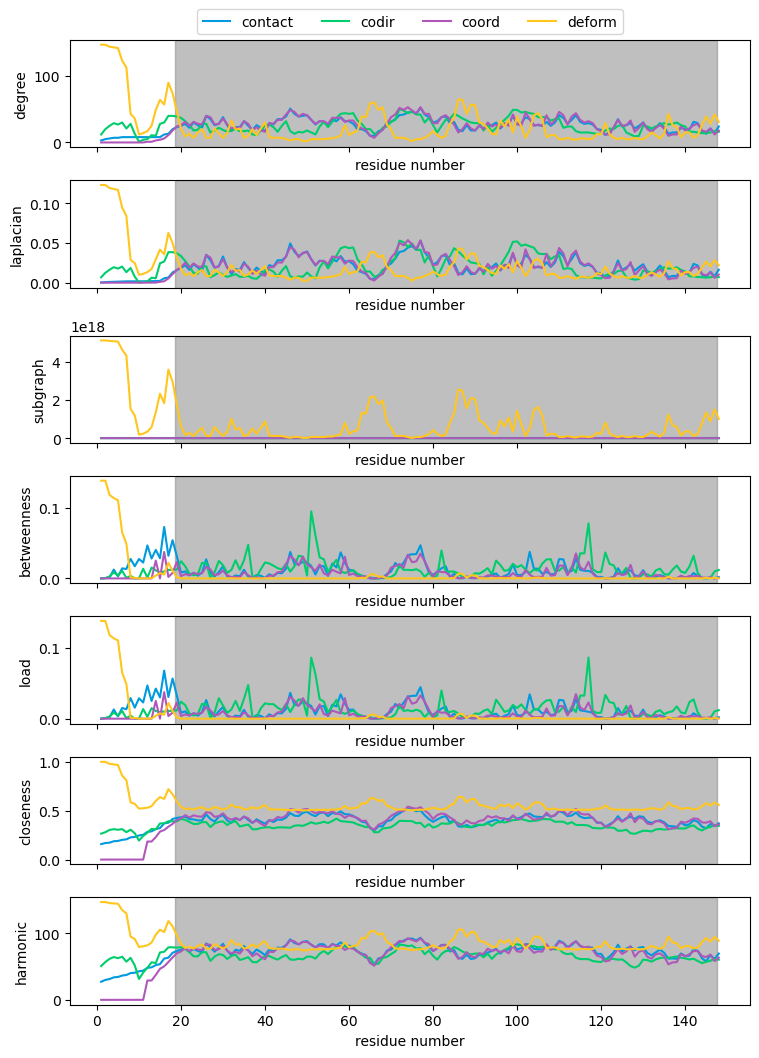

 >> A0A077S9N1: DOMAIN


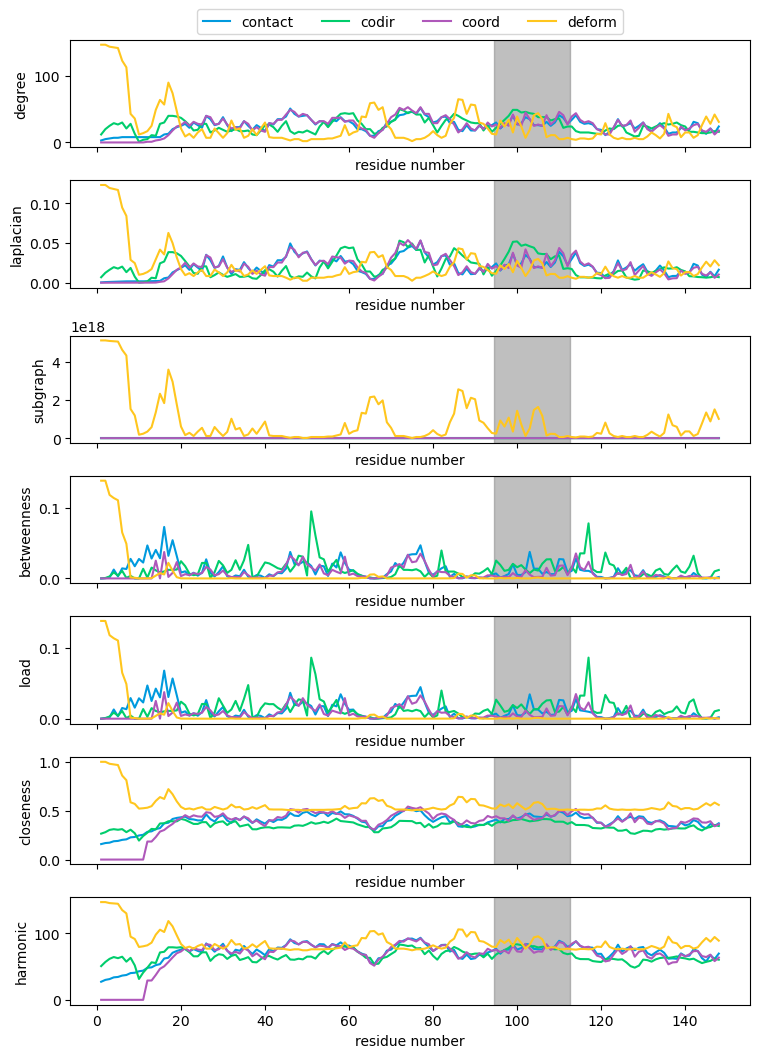

 >> A0A077S9N1: SIGNAL


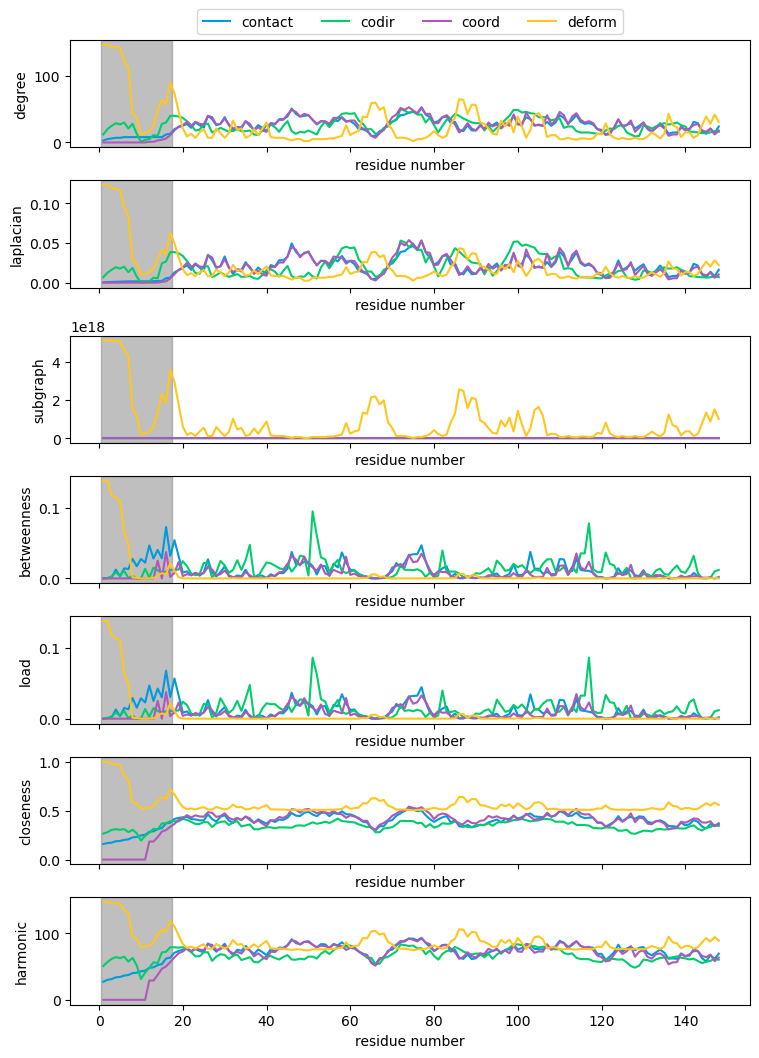

In [3]:
# PLOT EACH AND EVERY ANNOTATION FOR EACH PROTEIN SEPARATELY

metrics_to_plot = [
    'degree',
    'laplacian',

    'subgraph',

    'betweenness',
    # 'percolation', # equivalent to 'betweenness' when percolation is not set
    'load',

    'closeness',
    'harmonic',
]

stats_save_dir = f'{stats_dir}/{setup}'
files = os.listdir(stats_save_dir)
files.sort()

plt_show_cnt = 0
pbar = tqdm(files)
for f in pbar:
    accession = f.split(' - ')[-1][:-4]
    if accession not in uniprotkb_info:
        continue
    if len(uniprotkb_info[accession]) == 0:
        continue
    pbar.set_description(accession)

    # READ ALL SAVED STATS
    raw_header = np.loadtxt(
        f'{stats_save_dir}/{f}',
        delimiter=',',
        dtype=np.str_,
        comments=None,
        max_rows=1
    )
    raw_header[0] = raw_header[0][2:]
    raw_data = np.loadtxt(
        f'{stats_save_dir}/{f}',
        delimiter=',',
        dtype=np.str_
    )

    ####################################################################
    # PLOT
    ####################################################################

    for FT_category in uniprotkb_info[accession]:

        plots_save_dir = f'{plots_dir}/{setup}/on sequence/{FT_category}'
        os.makedirs(plots_save_dir, exist_ok=True)

        save_file = f'{plots_save_dir}/{accession}-{FT_category}.png'
        # if os.path.exists(save_file):
        #     continue

        fig, axes = plt.subplots(
            len(metrics_to_plot), 1,
            sharex=True, sharey=False,
            figsize=(7.48, 7.48/5*len(metrics_to_plot)),
            layout='constrained'
        )

        # PLOT METRICS
        for metric_idx, metric_name in enumerate(metrics_to_plot):
            ax = axes[metric_idx]

            for edge_type in edge_types:

                loc = np.argwhere(raw_header==f'{edge_type}_{metric_name}')[0]

                ax.plot(
                    raw_data[:,0].astype(np.int_) + 1,
                    raw_data[:,loc].astype(np.float_),
                    label=edge_type,
                    color=et_color[edge_type],
                )

            ax.set_xlabel('residue number')
            ax.set_ylabel(metric_name)

            # MARK CRITICAL RESIDUES

            for entry in uniprotkb_info[accession][FT_category]:
                resnums = entry['resnums'].split('..')
                annotation = entry['annotation']

                ax.axvspan(
                    int(resnums[0])-0.5,
                    int(resnums[-1])-0.5,
                    color='gray',
                    alpha=0.5
                    # linewidth=1,
                    # label='critical residue' if resnum == critial_resnums[0] else None
                )

        axes[0].legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.35),
            ncols=4
        )

        plt.savefig(
            save_file,
            dpi=300
        )
        if plt_show_cnt < 3:
            print(f' >> {accession}: {FT_category}')
            plt.show()
            plt_show_cnt += 1
        plt.close()


In [4]:

all_FT_categories = [
    d for d in os.listdir(f'{plots_dir}/{setup}/on sequence')
    if os.path.isdir(f'{plots_dir}/{setup}/on sequence/{d}')
]

# file count
entry_count = {
    FT_category: len([
        f for f in os.listdir(f'{plots_dir}/{setup}/on sequence/{FT_category}')
        if f.endswith('.png')
    ])
    for FT_category in all_FT_categories
}

# sort by count
entry_count = dict(sorted(entry_count.items(), key=lambda item: item[1], reverse=True))

for FT_category, count in entry_count.items():
    print(f'{FT_category:10s}: {count:2d} entries')



CHAIN     : 45 entries
DOMAIN    : 25 entries
BINDING   : 22 entries
HELIX     : 19 entries
REGION    : 18 entries
CONFLICT  : 17 entries
STRAND    : 17 entries
MOD_RES   : 16 entries
TURN      : 15 entries
MUTAGEN   : 14 entries
TRANSMEM  : 11 entries
COMPBIAS  :  9 entries
MOTIF     :  8 entries
INIT_MET  :  8 entries
ACT_SITE  :  7 entries
LIPID     :  6 entries
VAR_SEQ   :  6 entries
TOPO_DOM  :  5 entries
CROSSLNK  :  4 entries
SITE      :  4 entries
TRANSIT   :  3 entries
VARIANT   :  3 entries
PROPEP    :  3 entries
custom    :  3 entries
SIGNAL    :  3 entries
DNA_BIND  :  2 entries
CARBOHYD  :  2 entries
DISULFID  :  1 entries
COILED    :  1 entries
ZN_FING   :  1 entries


O31775


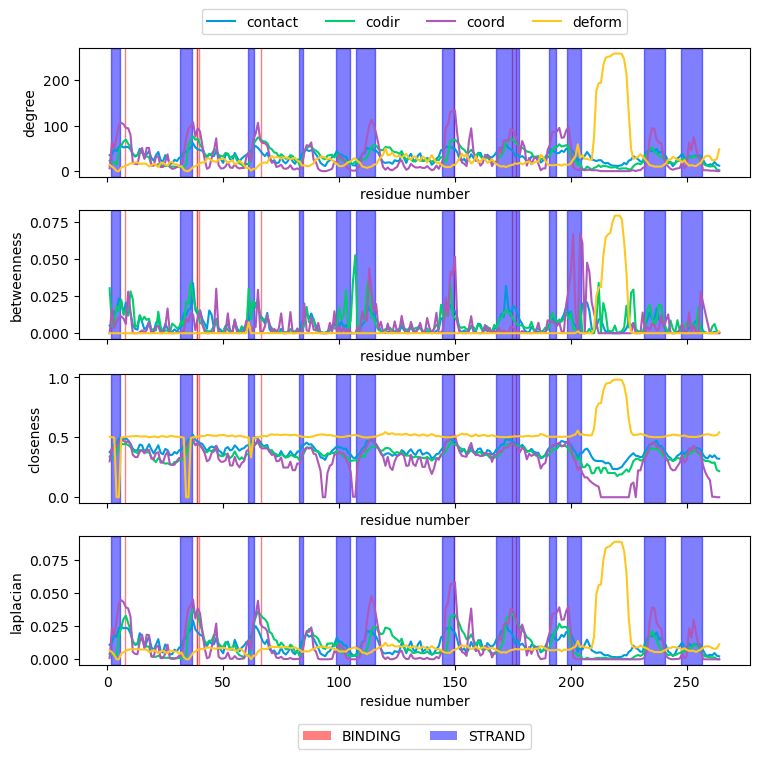

Q72JK8


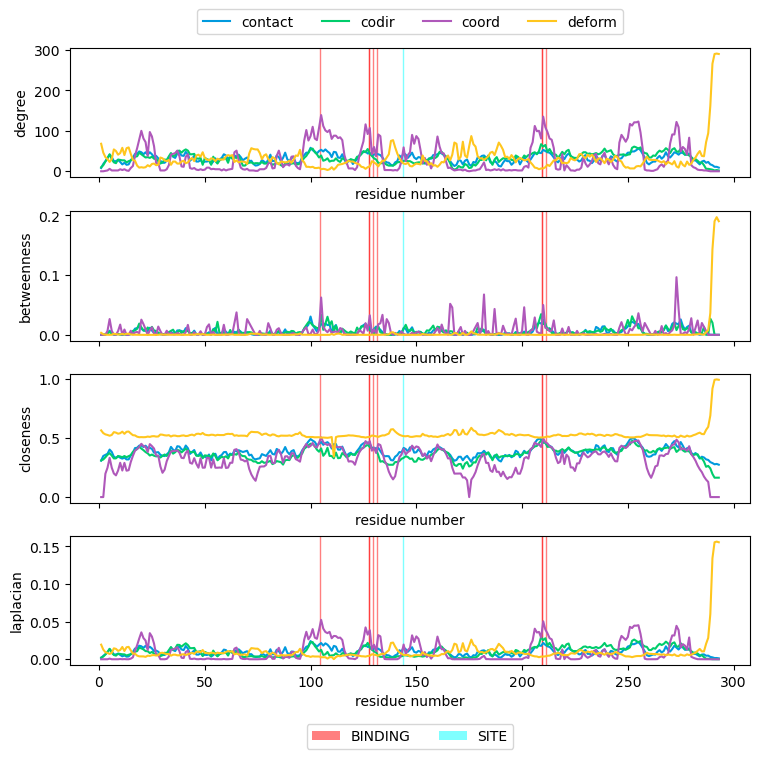

R4YR45


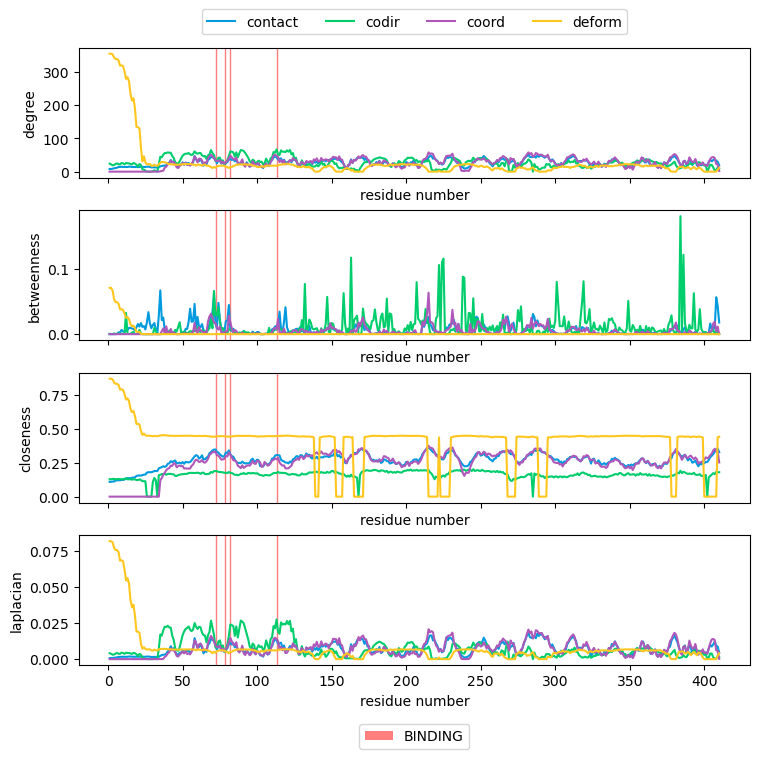

In [ ]:
# # PLOT ALL SELECTED ANNOTATIONS IN ONE FIGURE

# accessions_to_plot = [
#     'O31775',
#     'Q72JK8',
#     'R4YR45',
# ]
# metrics_to_plot = [
#     'degree',
#     'betweenness',
#     'closeness',
#     'laplacian'
# ]

# annotations_to_process = {
#     # 'ACT_SITE',
#     'BINDING': 'red',
#     # 'CHAIN',
#     # 'COILED',
#     # 'COMPBIAS',
#     # 'CONFLICT',
#     # 'CROSSLNK',
#     # 'DNA_BIND',
#     # 'DOMAIN',
#     # 'HELIX': 'green',
#     # 'INIT_MET',
#     # 'LIPID',
#     # 'MOD_RES',
#     # 'MOTIF',
#     # 'MUTAGEN',
#     # 'NON_TER',
#     # 'PROPEP',
#     # 'REGION',
#     # 'REPEAT',
#     # 'SIGNAL',
#     'SITE': 'cyan',
#     'STRAND': 'blue',
#     # 'TOPO_DOM',
#     # 'TRANSMEM',
#     # 'TURN',
#     # 'VARIANT',
#     # 'VAR_SEQ',
#     # 'ZN_FING',
# }

# stats_save_dir = f'{stats_dir}/{setup}'
# files = os.listdir(stats_save_dir)
# files.sort()

# for accession in accessions_to_plot:
#     print(accession)

#     plots_save_dir = f'{plots_dir}/{setup}/on sequence/custom'
#     os.makedirs(plots_save_dir, exist_ok=True)

#     # READ ALL SAVED STATS
#     raw_header = np.loadtxt(
#         f'{stats_save_dir}/metrics - {accession}.csv',
#         delimiter=',',
#         dtype=np.str_,
#         comments=None,
#         max_rows=1
#     )
#     raw_header[0] = raw_header[0][2:]
#     raw_data = np.loadtxt(
#         f'{stats_save_dir}/metrics - {accession}.csv',
#         delimiter=',',
#         dtype=np.str_
#     )

#     # PLOT
#     if len(set(uniprotkb_info[accession]) & set(annotations_to_process)) == 0:
#         continue

#     fig, axes = plt.subplots(
#         len(metrics_to_plot), 1,
#         sharex=True, sharey=False,
#         figsize=(7.48, 7.48/4*len(metrics_to_plot)),
#         layout='constrained'
#     )

#     for metric_idx, metric_name in enumerate(metrics_to_plot):
#         ax = axes[metric_idx]

#         for edge_type in edge_types:

#             loc = np.argwhere(raw_header==f'{edge_type}_{metric_name}')[0]

#             ax.plot(
#                 raw_data[:,0].astype(np.int_) + 1,
#                 raw_data[:,loc].astype(np.float_),
#                 label=edge_type,
#                 color=et_color[edge_type],
#             )

#         ax.set_xlabel('residue number')
#         ax.set_ylabel(metric_name)

#         # MARK CRITICAL RESIDUES
#         category_legend_elem = []
#         for FT_category in uniprotkb_info[accession]:
#             if FT_category not in annotations_to_process:
#                 continue

#             for entry in uniprotkb_info[accession][FT_category]:
#                 resnums = entry['resnums'].split('..')
#                 annotation = entry['annotation']

#                 ax.axvspan(
#                     int(resnums[0])-0.5,
#                     int(resnums[-1])-0.5,
#                     color=annotations_to_process[FT_category],
#                     alpha=0.5
#                     # linewidth=1,
#                     # label='critical residue' if resnum == critial_resnums[0] else None
#                 )

#             category_legend_elem.append(
#                 Patch(
#                     facecolor=annotations_to_process[FT_category],
#                     edgecolor=None,
#                     alpha=0.5,
#                     label=FT_category
#                 )
#             )

#     axes[0].legend(
#         loc='upper center',
#         bbox_to_anchor=(0.5, 1.35),
#         ncols=4
#     )
#     if len(category_legend_elem) > 0:
#         axes[-1].legend(
#             handles=category_legend_elem,
#             loc='upper center',
#             bbox_to_anchor=(0.5, -0.4),
#             ncols=6
#         )

#     plt.savefig(
#         f'{plots_save_dir}/{accession} - selected annotations.png',
#         dpi=300
#     )
#     plt.show()
#     plt.close()


O31775


/tmp/ipykernel_327093/3899602013.py:65: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  raw_data = np.loadtxt(


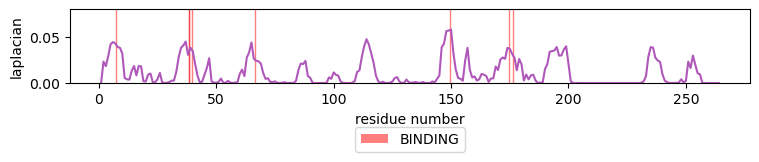

In [3]:
# FOR GRAPHICAL ABSTRACT

accessions_to_plot = [
    'O31775',
    # 'Q72JK8',
    # 'R4YR45',
]
metrics_to_plot = [
    # 'degree',
    # 'betweenness',
    # 'closeness',
    'laplacian'
]

annotations_to_process = {
    # 'ACT_SITE',
    'BINDING': 'red',
    # 'CHAIN',
    # 'COILED',
    # 'COMPBIAS',
    # 'CONFLICT',
    # 'CROSSLNK',
    # 'DNA_BIND',
    # 'DOMAIN',
    # 'HELIX': 'green',
    # 'INIT_MET',
    # 'LIPID',
    # 'MOD_RES',
    # 'MOTIF',
    # 'MUTAGEN',
    # 'NON_TER',
    # 'PROPEP',
    # 'REGION',
    # 'REPEAT',
    # 'SIGNAL',
    # 'SITE': 'cyan',
    # 'STRAND': 'blue',
    # 'TOPO_DOM',
    # 'TRANSMEM',
    # 'TURN',
    # 'VARIANT',
    # 'VAR_SEQ',
    # 'ZN_FING',
}

stats_save_dir = f'{stats_dir}/{setup}'
files = os.listdir(stats_save_dir)
files.sort()

for accession in accessions_to_plot:
    print(accession)

    plots_save_dir = f'{plots_dir}/{setup}/on sequence/custom'
    os.makedirs(plots_save_dir, exist_ok=True)

    # READ ALL SAVED STATS
    raw_header = np.loadtxt(
        f'{stats_save_dir}/metrics - {accession}.csv',
        delimiter=',',
        dtype=np.str_,
        comments=None,
        max_rows=1
    )
    raw_header[0] = raw_header[0][2:]
    raw_data = np.loadtxt(
        f'{stats_save_dir}/metrics - {accession}.csv',
        delimiter=',',
        dtype=np.str_
    )

    # PLOT
    if len(set(uniprotkb_info[accession]) & set(annotations_to_process)) == 0:
        continue

    fig, ax = plt.subplots(
        len(metrics_to_plot), 1,
        sharex=True, sharey=False,
        figsize=(7.48, 7.48/4*len(metrics_to_plot)*0.8),
        layout='constrained'
    )

    for metric_idx, metric_name in enumerate(metrics_to_plot):

        for edge_type in edge_types:
            if edge_type != 'coord':
                continue

            loc = np.argwhere(raw_header==f'{edge_type}_{metric_name}')[0]

            ax.plot(
                raw_data[:,0].astype(np.int_) + 1,
                raw_data[:,loc].astype(np.float32),
                label=edge_type,
                color=et_color[edge_type],
            )

        ax.set_xlabel('residue number')
        ax.set_ylabel(metric_name)

        # MARK CRITICAL RESIDUES
        category_legend_elem = []
        for FT_category in uniprotkb_info[accession]:
            if FT_category not in annotations_to_process:
                continue

            for entry in uniprotkb_info[accession][FT_category]:
                resnums = entry['resnums'].split('..')
                annotation = entry['annotation']

                ax.axvspan(
                    int(resnums[0])-0.5,
                    int(resnums[-1])-0.5,
                    color=annotations_to_process[FT_category],
                    alpha=0.5
                    # linewidth=1,
                    # label='critical residue' if resnum == critial_resnums[0] else None
                )

            category_legend_elem.append(
                Patch(
                    facecolor=annotations_to_process[FT_category],
                    edgecolor=None,
                    alpha=0.5,
                    label=FT_category
                )
            )

    # ax.legend(
    #     loc='upper center',
    #     bbox_to_anchor=(0.5, 1.35),
    #     ncols=4
    # )
    if len(category_legend_elem) > 0:
        ax.legend(
            handles=category_legend_elem,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.5),
            ncols=6
        )
    ax.set_ylim(0, 0.08)

    plt.savefig(
        f'{plots_save_dir}/{accession} - figure abstract.png',
        dpi=350,
        bbox_inches='tight'
    )
    plt.show()
    plt.close()
